In [6]:
import argparse
import os
import random
import math

from tqdm import tqdm
import numpy as np
from PIL import Image

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils

from dataset import MultiResolutionDataset
# from datasets import TextDataset, prepare_data
from model import StyledGenerator, Discriminator, TextProcess



In [2]:
transform = transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True),
        ]
    )


In [3]:
dataset = MultiResolutionDataset('./data/birds_lmdb', transform, max_length=18)

In [7]:
def sample_data(dataset, batch_size, image_size=8):
    dataset.resolution = image_size
    loader = DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=4)
    return loader

In [20]:
step = int(math.log2(4)) - 2
resolution = 4 * 2 ** step
loader = sample_data(
    dataset, 32, 32
)
data_loader = iter(loader)

In [21]:
l = []
for i,j  in data_loader:
    x = j
    break

In [22]:
x = next(data_loader)

In [24]:
x[1]

tensor([[  101,  1037,  4743,  2007,  1037,  2304,  2132,  1010,  3897, 23525,
          1010,  1998,  2304,  2519,  1012,   102,     0,     0],
        [  101,  2023,  2210,  4743,  2038,  1037,  2829,  2303,  1998,  1037,
          2317,  7579,  1012,   102,     0,     0,     0,     0],
        [  101,  4743,  2007,  2304,  3239,  1010, 19437,  3897, 23525,  1010,
          2829,  2519,  1998,  3897,  4410,  1998,  2422,  3897],
        [  101,  2023,  2312,  4743,  2038, 19504,  2304, 12261,  2035,  2058,
          1010,  1037,  2460,  4197,  2304,  3021,  1010,  1998],
        [  101,  1996,  4743,  2038,  1037,  2417,  6910,  2132,  1998,  4410,
          1010,  2021,  3484,  1997,  2049, 19813,  2015,  1998],
        [  101,  1037,  4743,  2007,  1037,  4317, 13012,  5654,  8787,  2099,
          3021,  1010,  2317,  3239,  4892,  1010,  1998,  2829],
        [  101,  2235,  4743,  2007,  1037,  3565,  2235,  3021,  1998,  1037,
          6638,  7388,  1998,  7579,  1012,   102, 

In [31]:
from io import BytesIO

import lmdb
import random
from PIL import Image
from torch.utils.data import Dataset
import torch
from pytorch_pretrained_bert import BertTokenizer

In [27]:
env = lmdb.open(
            './data/birds_lmdb',
            max_readers=32,
            readonly=True,
            lock=False,
            readahead=False,
            meminit=False,
        )

In [29]:
with env.begin(write=False) as txn:
    length = int(txn.get('length'.encode('utf-8')).decode('utf-8'))

In [30]:
length

11788

In [45]:
with env.begin(write=False) as txn:
    txt = []
    for index in range(length):
        for i in range(5):
            txt_key = f'txt-{i}-{str(index).zfill(5)}'.encode('utf-8')
            txt.append(txn.get(txt_key))


In [59]:
stat = []
for i in txt:
    stat.append(len(i.split()))

In [60]:
np.mean(stat)

15.898727519511368

(array([1.6000e+02, 1.9619e+04, 3.1293e+04, 5.7910e+03, 1.5050e+03,
        4.3000e+02, 1.0200e+02, 2.4000e+01, 1.0000e+01, 6.0000e+00]),
 array([ 1. ,  7.4, 13.8, 20.2, 26.6, 33. , 39.4, 45.8, 52.2, 58.6, 65. ]),
 <a list of 10 Patch objects>)

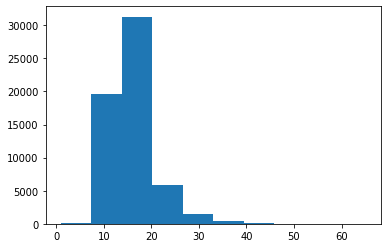

In [61]:
import matplotlib.pyplot as plt
plt.hist(stat)

In [62]:
np.quantile(stat, [0.5,0.75,0.95])

array([15., 18., 25.])

In [ ]:
txt

In [4]:
def KL_loss(mu, logvar):
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.mean(KLD_element).mul_(-0.5)
    return KLD    

In [8]:
mu = torch.tensor(1.0)
logvar = torch.tensor(2.0) 
mu.pow(2).add_(logvar.exp()).mul_(-1)

tensor(-8.3891)